## Imports 

In [17]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow / Keras (for dataset)
import tensorflow as tf
from keras.datasets import mnist

# Scikit-learn (for validation split)
from sklearn.model_selection import train_test_split


## Load and Preprocess MNIST Data


In [18]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test  = x_test.reshape(-1, 28, 28, 1)
print(x_train.shape, x_test.shape)


(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 28, 28, 1) (10000, 28, 28, 1)


## Sample MNIST Digits

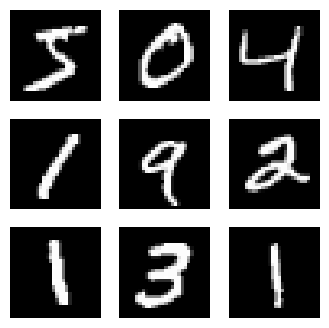

In [19]:

plt.figure(figsize=(4,4))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


## Validation Set

In [20]:

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)


(54000, 28, 28, 1) (6000, 28, 28, 1) (54000,) (6000,)


## CNN


In [21]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Input(shape=(28, 28, 1)),  # input explicitly defined here
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, y_val)
)


Epoch 1/10
  9/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2152 - loss: 2.2413  

KeyboardInterrupt: 

### Saving the model for future use

In [ ]:
model.save('mnist_cnn_model.keras')


### Training Curves and Validation Curves

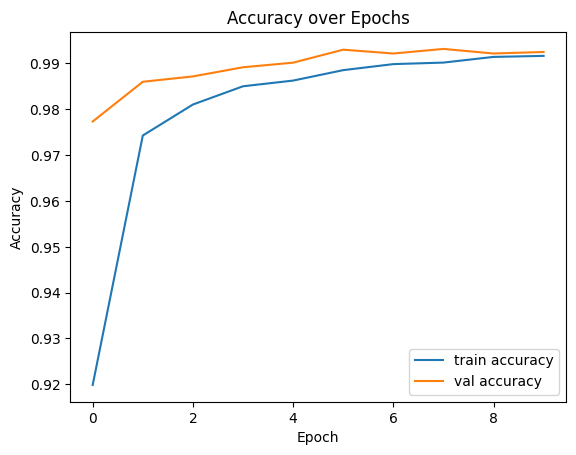

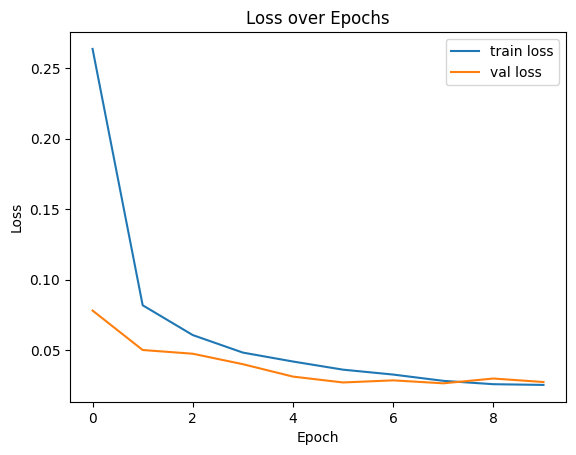

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Confusion Matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


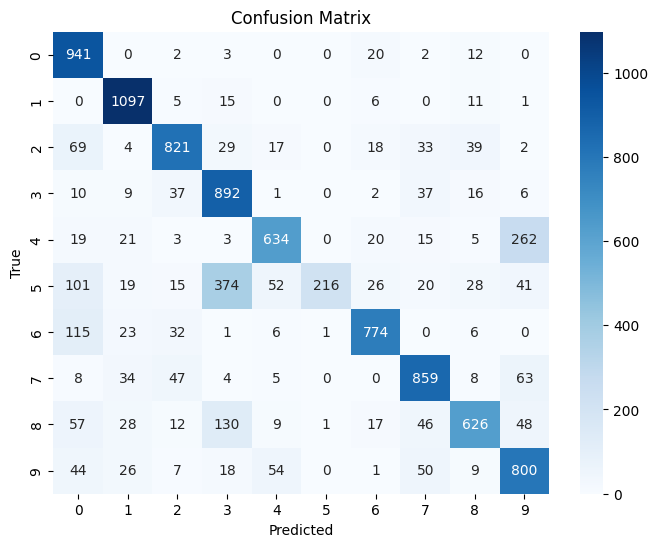

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on test set
y_pred = model.predict(x_test)
y_pred_labels = y_pred.argmax(axis=1)  # if using softmax output

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Prediction pipeline

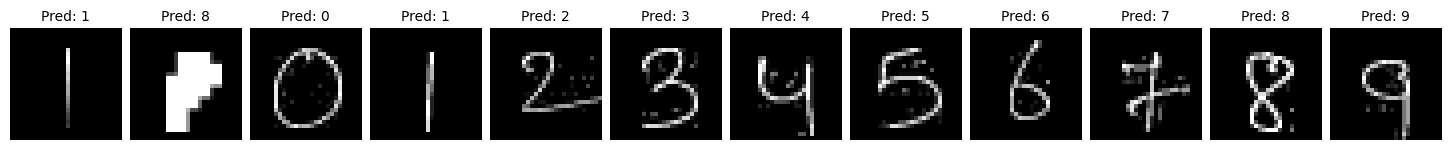

Predicted number: 180123456789


In [ ]:
'''import cv2
from keras.models import load_model

# Load trained model
model = load_model("mnist_cnn_model.keras")

# --- Preprocessing helper ---
def preprocess_digit(roi):
    # Thicken thin strokes selectively
    if roi.shape[1] < 15:
        roi = cv2.dilate(roi, np.ones((2, 2), np.uint8), iterations=1)

    # Resize to fit in a 20x20 box while keeping aspect ratio
    h, w = roi.shape
    if h > w:
        new_h = 20
        new_w = max(1, int(w * (20 / h)))
    else:
        new_w = 20
        new_h = max(1, int(h * (20 / w)))
    digit = cv2.resize(roi, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Pad to 28x28 and center
    pad_top = (28 - new_h) // 2
    pad_bottom = 28 - new_h - pad_top
    pad_left = (28 - new_w) // 2
    pad_right = 28 - new_w - pad_left
    digit = cv2.copyMakeBorder(digit, pad_top, pad_bottom, pad_left, pad_right,
                               borderType=cv2.BORDER_CONSTANT, value=0)

    # Center by center-of-mass
    ys, xs = np.nonzero(digit)
    if len(xs) and len(ys):
        cx = int(np.mean(xs))
        cy = int(np.mean(ys))
        shift_x = int(14 - cx)
        shift_y = int(14 - cy)
        M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
        digit = cv2.warpAffine(digit, M, (28, 28), borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    # Normalize and return
    digit = digit.astype("float32") / 255.0
    return digit  # shape: (28, 28)


# --- Main function: predict digits from image ---
def predict_sequence_from_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Adaptive thresholding
    thresh = cv2.adaptiveThreshold(gray, 255,
                                   cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV,
                                   blockSize=11, C=3)

    # Find and sort contours
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = [cv2.boundingRect(c) for c in contours]
    boxes = sorted(boxes, key=lambda b: b[0])

    preprocessed_tiles = []
    for (x, y, w, h) in boxes:
        if w < 5 or h < 5:
            continue
        roi = thresh[y:y+h, x:x+w]
        preprocessed_tiles.append(preprocess_digit(roi))

    if not preprocessed_tiles:
        print("No digits detected.")
        return ""

    # --- Batch prediction for speed ---
    batch = np.array(preprocessed_tiles).reshape(-1, 28, 28, 1)
    predictions = model.predict(batch, verbose=0)
    predicted_digits = [str(np.argmax(p)) for p in predictions]

    # --- Display results ---
    plt.figure(figsize=(max(6, len(preprocessed_tiles) * 1.2), 3), constrained_layout=True)
    for i, digit_img in enumerate(preprocessed_tiles):
        plt.subplot(1, len(preprocessed_tiles), i + 1)
        plt.imshow(digit_img, cmap="gray")
        plt.title(f"Pred: {predicted_digits[i]}", fontsize=10)
        plt.axis("off")
    plt.show()

    # --- Final output ---
    result = "".join(predicted_digits)
    print("Predicted number:", result)
    return result


# --- Run on your input image ---
predicted_number = predict_sequence_from_image("multi_digit4.jpeg")'''


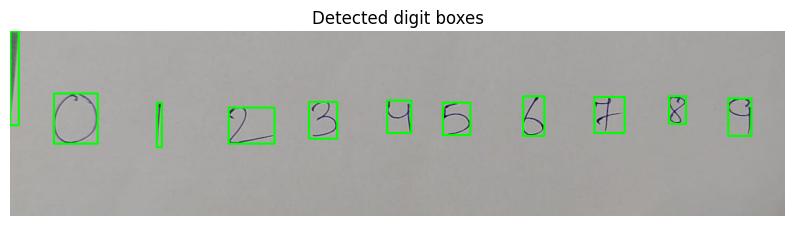

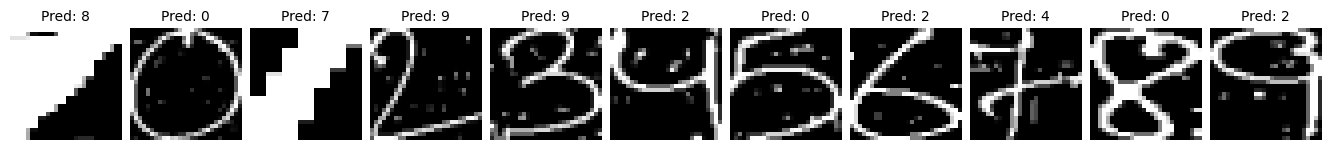

Predicted number: 80799202402


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Load EMNIST-trained model (digits 0–9)
model = load_model("emnist_cnn_model.keras")

# --- Preprocessing helper tuned for EMNIST ---
def preprocess_digit(roi):
    """
    roi: binary image (0 background, 255 digit) from adaptive threshold.
    Returns a (28, 28) float32 image in [0, 1].
    """
    # Ensure type
    roi = roi.astype("uint8")

    # Slightly thicken very thin digits (optional)
    h, w = roi.shape
    if min(h, w) < 14:
        roi = cv2.dilate(roi, np.ones((2, 2), np.uint8), iterations=1)

    # Directly resize to 28x28 (EMNIST was trained on already-centered 28x28 digits)
    digit = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)

    # Normalize
    digit = digit.astype("float32") / 255.0
    return digit  # shape: (28, 28)

import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_digit_boxes(thresh, min_area=80, x_gap=4):
    """
    thresh: binary image (0 / 255), digits in white (255) on black background.
    Returns a list of merged bounding boxes (x, y, w, h), one per digit.
    min_area: ignore very small noise blobs.
    x_gap: horizontal gap (pixels) within which boxes will be merged.
    """

    # Find raw contours
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if w * h < min_area:
            continue
        boxes.append((x, y, w, h))

    # Sort left-to-right
    boxes = sorted(boxes, key=lambda b: b[0])

    # Merge overlapping / very close boxes (handles 0, 6, 8, 9 pieces etc.)
    merged = []
    for (x, y, w, h) in boxes:
        if not merged:
            merged.append([x, y, w, h])
            continue

        lx, ly, lw, lh = merged[-1]

        # If new box starts very close to (or inside) previous box in x,
        # and vertically overlaps, treat them as same digit and merge.
        if x <= lx + lw + x_gap and not (y > ly + lh or ly > y + h):
            nx = min(x, lx)
            ny = min(y, ly)
            nx2 = max(x + w, lx + lw)
            ny2 = max(y + h, ly + lh)
            merged[-1] = [nx, ny, nx2 - nx, ny2 - ny]
        else:
            merged.append([x, y, w, h])

    return [tuple(b) for b in merged]


# --- Main function: predict digits from image ---
def predict_sequence_from_image(image_path, debug_boxes=True):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Adaptive threshold: white digits (255) on black (0)
    thresh = cv2.adaptiveThreshold(gray, 255,
                                   cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV,
                                   blockSize=11, C=3)

    # Small morphological close to connect broken strokes, reduce stray blobs
    kernel = np.ones((3, 3), np.uint8)
    thresh_clean = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Get merged bounding boxes (one per digit ideally)
    boxes = get_digit_boxes(thresh_clean, min_area=80, x_gap=4)

    # Optional: visualize bounding boxes on original image
    if debug_boxes:
        vis = img.copy()
        for (x, y, w, h) in boxes:
            cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)
        plt.figure(figsize=(10, 3))
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Detected digit boxes")
        plt.show()

    preprocessed_tiles = []
    for (x, y, w, h) in boxes:
        roi = thresh_clean[y:y + h, x:x + w]
        preprocessed_tiles.append(preprocess_digit(roi))

    if not preprocessed_tiles:
        print("No digits detected.")
        return ""

    batch = np.array(preprocessed_tiles).reshape(-1, 28, 28, 1)
    predictions = model.predict(batch, verbose=0)
    predicted_digits = [str(np.argmax(p)) for p in predictions]

    # Show tiles with predictions for debugging
    plt.figure(figsize=(max(6, len(preprocessed_tiles) * 1.2), 3), constrained_layout=True)
    for i, digit_img in enumerate(preprocessed_tiles):
        plt.subplot(1, len(preprocessed_tiles), i + 1)
        plt.imshow(digit_img, cmap="gray")
        plt.title(f"Pred: {predicted_digits[i]}", fontsize=10)
        plt.axis("off")
    plt.show()

    result = "".join(predicted_digits)
    print("Predicted number:", result)
    return result



# Example call
predicted_number = predict_sequence_from_image("multi_digit4.jpeg")
